this notebook trys to visulize neurons using keras-vis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import os.path
import numpy as np
import pickle
from skimage.io import imsave
from itertools import product
from scipy.stats import pearsonr

In [2]:
from keras import layers, models
from keras import backend as K
# you must do this. otherwise keras-vis may get screwed up.
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [3]:
from tang_jcompneuro import dir_dictionary
from tang_jcompneuro.io import load_split_dataset_idx, load_image_dataset, load_split_dataset_pretrained_pca_params, load_split_dataset
from skimage.transform import rescale
from leelabtoolbox.preprocessing import pipeline
from tang_jcompneuro.model_fitting_postprocess import load_one_cnnpre_model

In [4]:
# layer_to_use = 'conv3_1'

In [5]:
def load_one_keras_model(last_layer, neuron_idx, seed=0):
    vgg_info_filename = os.path.join(dir_dictionary['analyses'], 'vgg19_pytorch_dump.pkl')
    with open(vgg_info_filename, 'rb') as f:
        vgg19_info = pickle.load(f)
    input_this = layers.Input(shape=(1,224,224), name='input')
#     input_this_2 = input_this*2.0
#     print(input_this)
#     # then do normalization.
#     # check
#     # http://pytorch.org/docs/master/torchvision/models.html
    input_this_channel_r = layers.Lambda(lambda x: (x - 0.485)/0.229, name='input_r')(input_this)
#     print(input_this_channel_r)
    input_this_channel_g = layers.Lambda(lambda x: (x - 0.456)/0.224, name='input_g')(input_this)
    input_this_channel_b = layers.Lambda(lambda x: (x - 0.406)/0.225, name='input_b')(input_this)
    x = layers.Concatenate(axis=1, name='input_rgb')([input_this_channel_r, input_this_channel_g, input_this_channel_b])
#     print(x)
#     x = input_this
    # https://stackoverflow.com/questions/47289116/element-wise-multiplication-with-broadcasting-in-keras-custom-layer
    # tricky.
    # thankfully, we don't need it any more.
    
    weights_dict, slice_dict = vgg19_info['vgg19_weights_dict'], vgg19_info['slicing_dict']
    
    # load pca stuff 
    pca_mean, pca_components = load_split_dataset_pretrained_pca_params('MkA_Shape', 'all',
                                                                        suffix=f'vgg19/legacy/{last_layer}',
                                                                        seed=seed)
    
    
    model_this = load_one_cnnpre_model('MkA_Shape', 'all', f'vgg19+legacy+{last_layer}', neuron_idx, seed=seed)
    
    assert last_layer in weights_dict.keys()
    for layer_name, weights_dict_this in weights_dict.items():
#         print(layer_name)
        if weights_dict_this is not None:
            # then conv.
            num_channel = weights_dict_this['bias'].size
#             print(num_channel)
            # y for capture.
            def weight_init(shape, y=weights_dict_this['weight']):
                return y.transpose(2,3,1,0)
            def bias_init(shape, y=weights_dict_this['bias']):
                return y
            x = layers.Conv2D(num_channel, (3,3), activation='relu', padding='same', data_format='channels_first',
                       kernel_initializer=weight_init,
                       bias_initializer=bias_init,
                      name=layer_name)(x)
        else:
            x = layers.MaxPooling2D((2, 2), strides=(2, 2), name=layer_name,data_format='channels_first')(x)
        
        if layer_name == last_layer:
            break
#     print(x)
    # then slice
    slice_r, slice_c = slice_dict[layer_name]
    x = layers.Lambda(lambda x: x[:,:,slice_r, slice_c], name='slice')(x)
    x = layers.Flatten(name='flatten')(x)
    pca_mean_keras = K.variable(pca_mean[np.newaxis])
    pca_comp_keras = K.variable(pca_components.T)
    x = layers.Lambda(lambda x: K.dot(x-pca_mean_keras, pca_comp_keras),name='pca')(x)
    
    # final glm
    glm_w_keras = K.variable(model_this['model_coeff'][:,np.newaxis])
    x = layers.Lambda(lambda x: K.dot(x, glm_w_keras) + model_this['model_bias'],name='glm')(x)
# for testing raw features
#     return models.Model(input_this, x, name=f'vgg19_{last_layer}'), list(weights_dict.keys())

# for testing glm prediction.
    return models.Model(input_this, x, name=f'vgg19_{last_layer}'), model_this['y_test_hat'], model_this['corr']

In [6]:
# used by all my debug code
# a, y_test_hat = load_one_keras_model(layer_to_use, 553)
# a.summary()

In [7]:
# working on testing set.
# data_idx = load_split_dataset_idx('MkA_Shape', 'all', True, last_val=False, seed=0)[2]

In [8]:
# img = load_image_dataset('Shape_9500', patch_size=160, normalize_cnn_format=False)[data_idx]

In [9]:
# # load all images.
# # check https://github.com/leelabcnbc/tang_jcompneuro_revision/blob/master/tang_jcompneuro/cnn_pretrained.py
# def preprocess_dataset(images):
#     # rescale
#     images = np.asarray([rescale(im, scale=2/3, order=1, mode='edge') for im in images])

#     # make sure images are 3D
#     if images.ndim == 3:
#         images = np.concatenate((images[..., np.newaxis],) * 3, axis=-1)
#     assert images.ndim == 4 and images.shape[-1] == 3
#     assert np.all(images <= 1) and np.all(images >= 0)

#     # use leelab-toolbox pipeline
#     steps_naive = ['putInCanvas']
#     pars_naive = {'putInCanvas': {'canvas_size': (224, 224),
#                                   'canvas_color': np.array([1.0, 1.0, 1.0]),
#                                   },
#                   }
#     pipeline_naive, realpars_naive, order_naive = pipeline.preprocessing_pipeline(steps_naive, pars_naive,
#                                                                                   order=steps_naive)
#     images_new = pipeline_naive.transform(images.astype(np.float32, copy=False))
#     images_new = np.transpose(images_new, (0, 3, 1, 2))
#     return images_new[:, 0:1]

In [10]:
# img_ready = preprocess_dataset(img)

In [11]:
# tested when last layer is glm.
# y_test_this = np.exp(a.predict(img_ready, batch_size=100))
# print(pearsonr(y_test_this.ravel(), y_test_hat.ravel())[0])

In [12]:
# these code were tested when last layer is pca.
# 
# data_x = load_split_dataset('MkA_Shape', 'all', True, slice(None), last_val=False, seed=0,
#                            suffix=f'vgg19/legacy/{layer_to_use}')[4]
# features_this = a.predict(img_ready, batch_size=100)
# pearsonr(data_x.ravel(), features_this.ravel())

In [13]:
# these code were tested when last layer is slice.
# and my model gen function returns blob_names

# # get features
# features_this = a.predict(img_ready, batch_size=100)

# # get reference features.
# def load_original_features(layer_name):
#     file_in = os.path.join(dir_dictionary['features'], 'cnn_feature_extraction.hdf5')
#     layer_idx = blob_names.index(layer_name)
#     key_to_extract = '/'.join(['vgg19', 'legacy', str(layer_idx)])
#     with h5py.File(file_in, 'r') as f:
#         feature_this = f[f'Shape_9500/{key_to_extract}'][data_idx.tolist()].astype(np.float64, copy=False)
#     print(feature_this.shape)
#     return feature_this

In [14]:
# do visualization
plot_save_dir = os.path.join(dir_dictionary['plots'], 'main', 'cnnpre_neuron_vis')
os.makedirs(plot_save_dir, exist_ok=True)
assert os.path.exists(plot_save_dir)
from vis.visualization import visualize_activation
from vis.utils import utils

In [15]:
def do_one_case(layer_to_work_on, neuron_to_work_on):
    model_this, y_test_hat, corr = load_one_keras_model(layer_to_work_on, neuron_to_work_on)
#     print(model_this.summary())
    
#     # check it's good.
#     y_test_hat_this = np.exp(model_this.predict(img_ready, batch_size=100))
#     print(pearsonr(y_test_hat_this.ravel(), y_test_hat.ravel())[0])
    
    layer_idx = utils.find_layer_idx(model_this, 'glm')
    
    images_all = []
    print('corr', corr)
    for _ in range(5):
        np.random.seed(_)
        img = visualize_activation(model_this, layer_idx, filter_indices=0,
                                           tv_weight=20,lp_norm_weight=10,input_range=(-1.0,1.0))
        # 28x28 in this 2/3 scaled space roughly maps to original 40x40.
        img = np.broadcast_to((img+1)/2, shape=(224,224,3))[112-14:112+14,112-14:112+14]
        plt.close('all')
        
        images_all.append(img)
        
        plt.imshow(img)
        plt.show()
    img_final = utils.stitch_images(images_all, cols=5, margin=5)
    img_final = np.pad(img_final, [(5,5),(5,5),(0,0)], mode='constant')
    imsave(os.path.join(plot_save_dir, f'{neuron_to_work_on}_{layer_to_work_on}.png'), img_final)

conv2_1 4
corr 0.684149026052


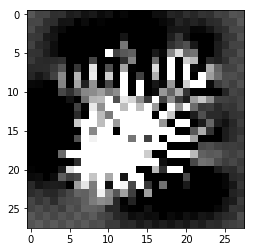

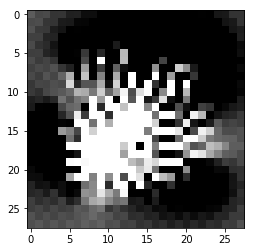

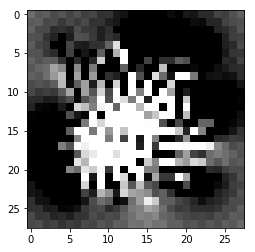

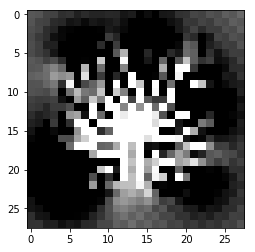

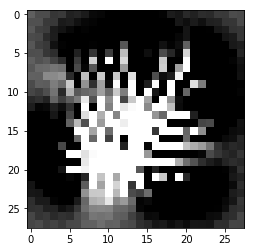

/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


conv3_1 4
corr 0.755313141546


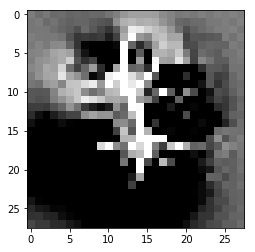

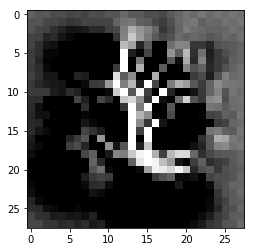

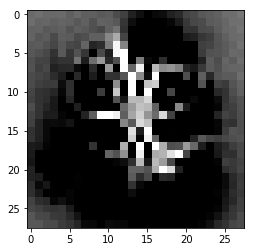

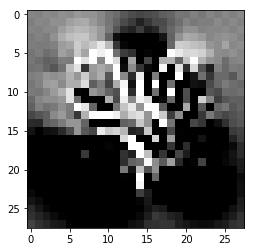

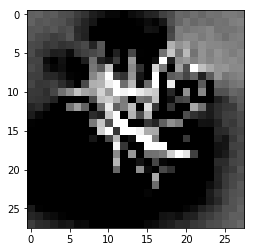

conv4_1 4
corr 0.762173730094


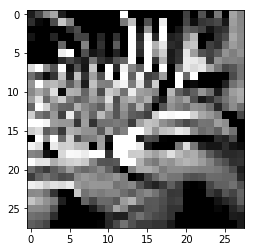

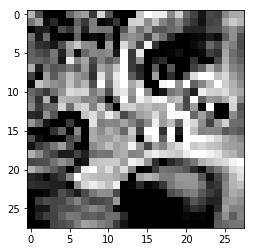

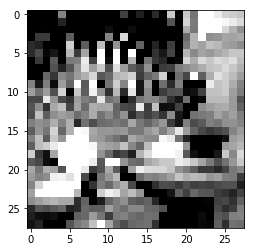

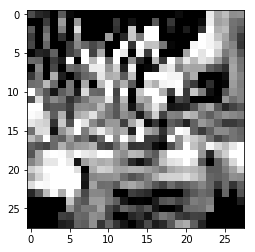

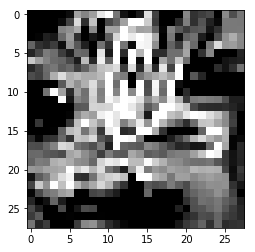

conv2_1 459
corr 0.772971573014


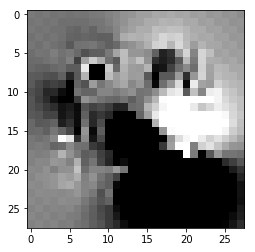

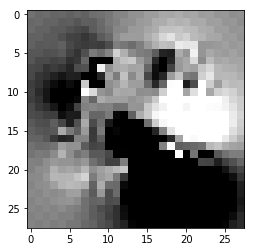

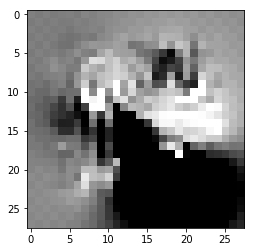

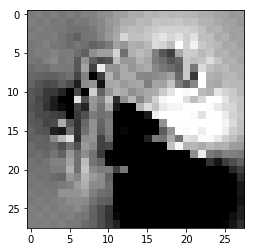

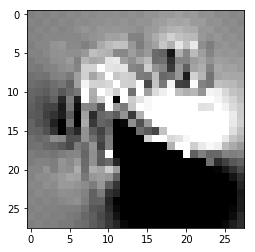

conv3_1 459
corr 0.784562766602


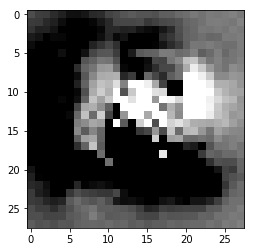

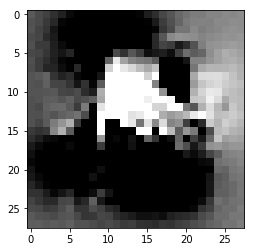

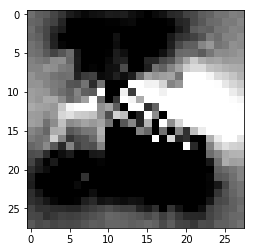

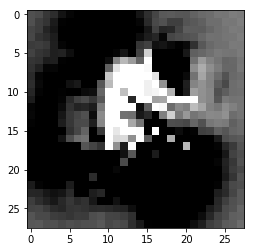

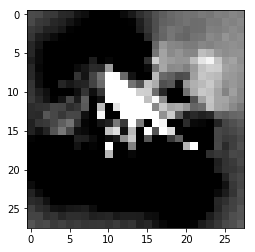

conv4_1 459
corr 0.766615670746


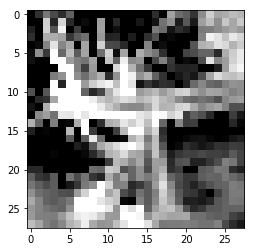

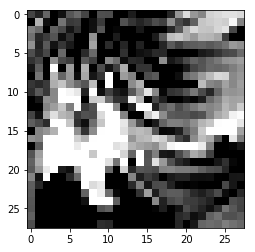

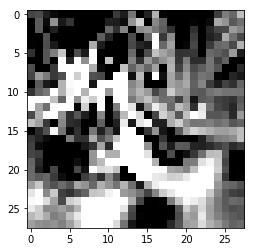

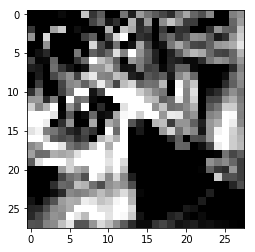

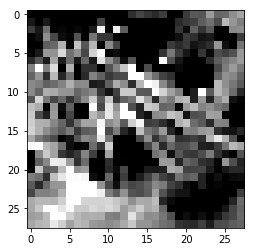

conv2_1 578
corr 0.780361269338


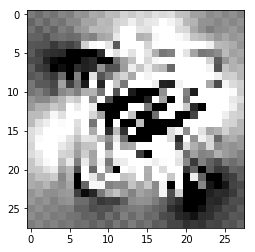

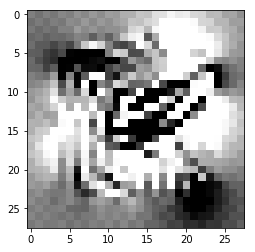

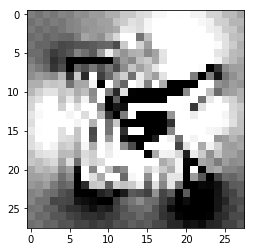

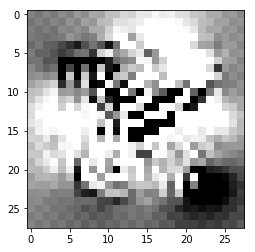

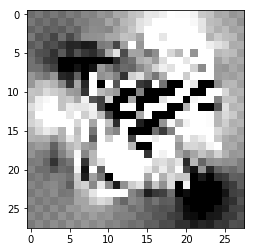

conv3_1 578
corr 0.810495796335


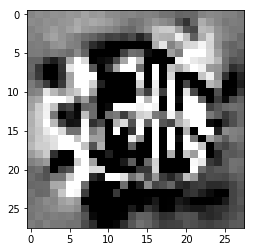

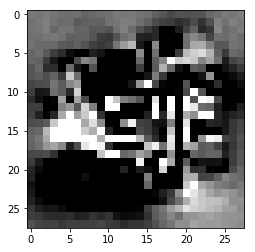

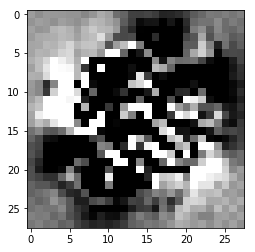

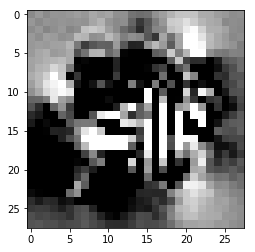

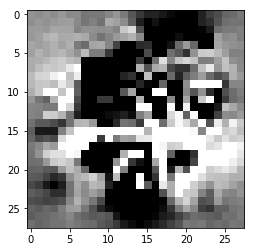

conv4_1 578
corr 0.809972857244


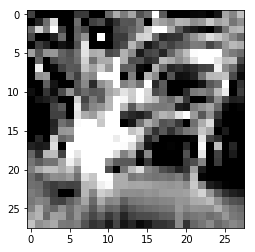

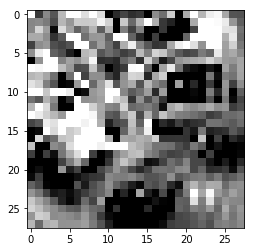

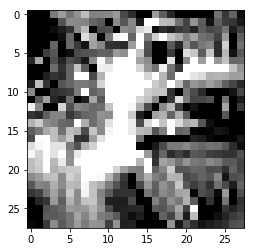

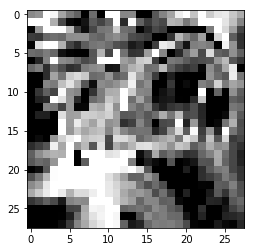

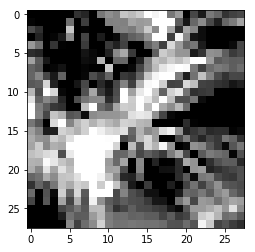

conv2_1 1079
corr 0.476929449905


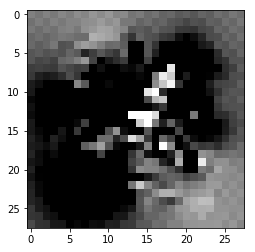

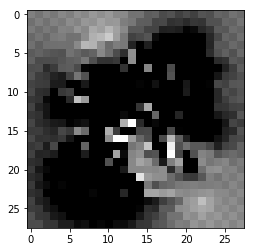

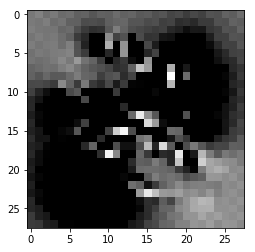

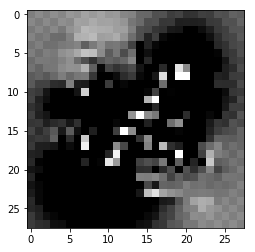

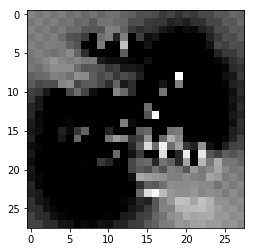

conv3_1 1079
corr 0.524110048203


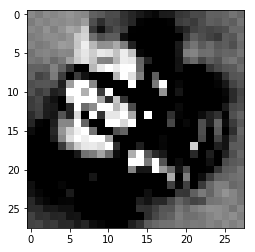

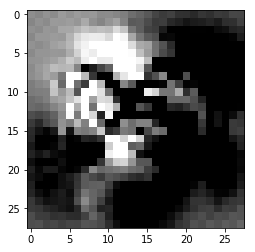

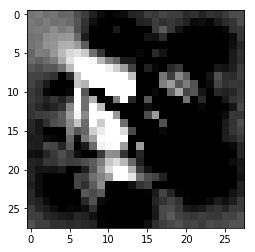

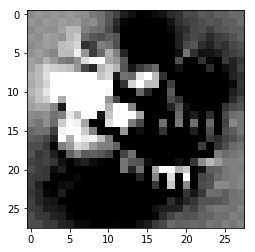

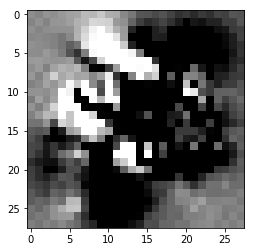

conv4_1 1079
corr 0.573720293775


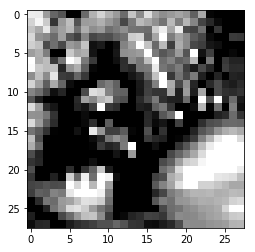

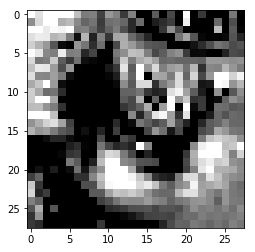

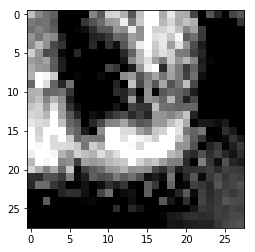

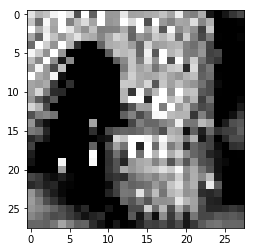

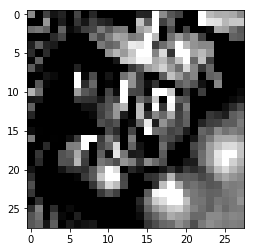

conv2_1 553
corr 0.469015632321


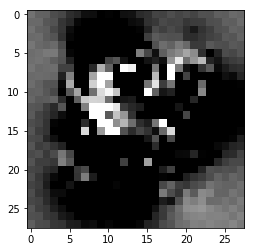

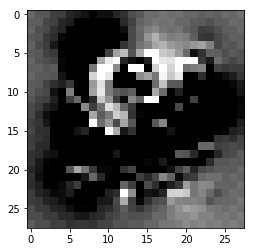

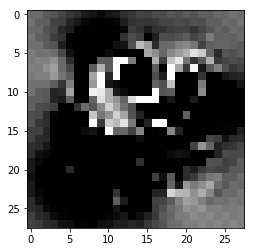

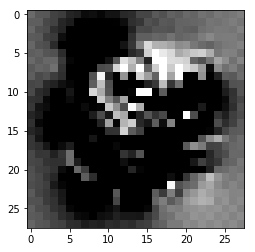

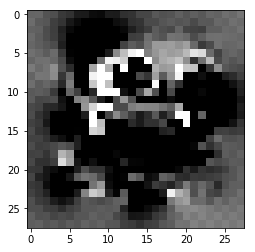

conv3_1 553
corr 0.572193615532


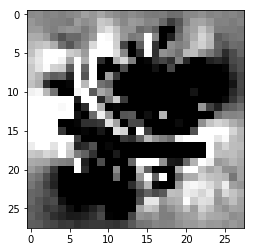

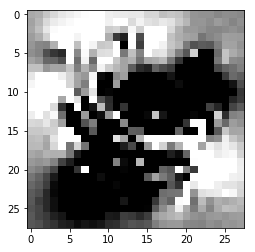

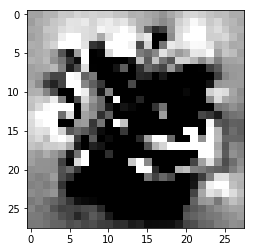

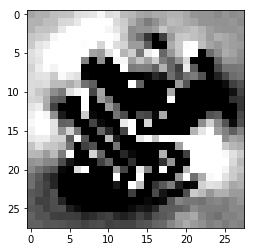

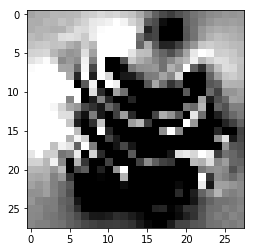

conv4_1 553
corr 0.660186108857


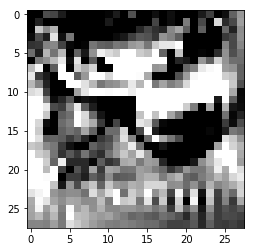

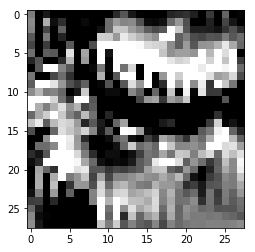

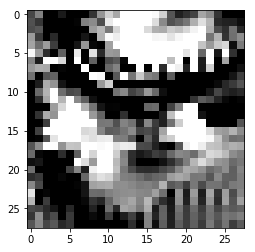

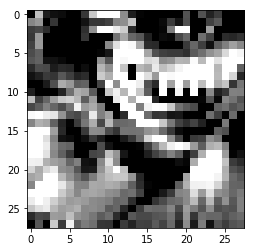

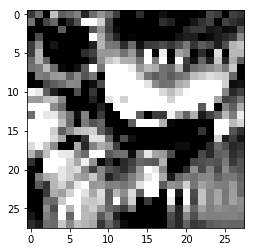

In [16]:
def do():
    for idx, layer in product((4, 459, 578, 1079, 553), ('conv2_1', 'conv3_1', 'conv4_1')):
#     for idx in (553,):
        print(layer, idx)
        do_one_case(layer, idx)
do()